In [1]:
%matplotlib inline
import cPickle as pkl
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM, GRU, SimpleRNN, TimeDistributed, Activation
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [3]:
dataset = pkl.load(open('dataset.pkl', 'rb'))

In [4]:
rnndata = [dataset[u] for u in dataset.keys() if "bot" not in str(u)]
rnndata = [h for h in rnndata if len(h) == 40]#150 > len(h) and len(h) > 140]
rnndata = np.array(rnndata) #+ 1

In [5]:
## Hyperparameters

# max sequence length.
maxlen = 39
vocab_size = max([max(x) for x in rnndata])+1
hidden = 25
print vocab_size

28


In [6]:
print('Splitting data...')
x_train = rnndata[:int(len(rnndata)*.9)]
y_train = to_categorical(np.array(x_train)[:,1:], num_classes=None).reshape(len(x_train),maxlen,vocab_size)
x_train = np.array(x_train)[:,:-1]
x_test = rnndata[int(len(rnndata)*.9):]
y_test = to_categorical(np.array(x_test)[:,1:], num_classes=None).reshape(len(x_test),maxlen,vocab_size)
x_test = np.array(x_test)[:,:-1]
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)

Splitting data...
(1466, 'train sequences')
(163, 'test sequences')
Pad sequences (samples x time)
('x_train shape:', (1466, 39))
('y_train shape:', (1466, 39, 28))
('x_test shape:', (163, 39))


In [7]:
print('Build model...')
model = Sequential()
model.add(Embedding(maxlen, hidden))
model.add(LSTM(hidden, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size)))
model.add(Activation(activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Build model...


In [182]:
model.fit(x_train, y_train, batch_size=1, nb_epoch=1, verbose=1)

Epoch 1/1
1466/1466 [==============================] - 169s - loss: 1.4190 - acc: 0.5948   


In [184]:
# only probabilities for push to same
model.predict(x_train[:2])[:,:,8]

array([[ 0.53190732,  0.73210365,  0.49607837,  0.37680081,  0.56965637,
         0.33259222,  0.54526728,  0.03003332,  0.49743149,  0.56810021,
         0.67079663,  0.71695769,  0.74097621,  0.75773829,  0.41169599,
         0.34631202,  0.49114072,  0.60219252,  0.52182341,  0.36765316,
         0.56983232,  0.34266227,  0.60488969,  0.62855732,  0.69140041,
         0.72843754,  0.55654669,  0.35963205,  0.3039937 ,  0.0453179 ,
         0.11452239,  0.45874083,  0.51785058,  0.5348019 ,  0.43377963,
         0.57761008,  0.49403003,  0.58711571,  0.67757785],
       [ 0.53190732,  0.73210365,  0.83282137,  0.87502134,  0.8977105 ,
         0.91134244,  0.9198283 ,  0.92523581,  0.92877382,  0.93115669,
         0.93280965,  0.93398786,  0.93484819,  0.93548977,  0.93597692,
         0.93635243,  0.93664527,  0.93687612,  0.93706012,  0.93720722,
         0.93732607,  0.93742234,  0.93750077,  0.93756491,  0.93761718,
         0.93766052,  0.9376958 ,  0.93772507,  0.93774939,  0.

In [187]:
model.evaluate(x_train[:20], y_train[:20], verbose=1, sample_weight=None)

20/20 [==============================] - 0s


[1.375880241394043, 0.60384613275527954]

## Autoencoder

In [162]:
from keras.layers.recurrent import LSTM
from keras.optimizers import Adagrad
from keras.losses import sparse_categorical_crossentropy
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model

from sklearn.manifold import TSNE

In [112]:
embedding_size = 5
encoding_size = 5
x_train = x_train
x_out = to_categorical(np.array(x_train), num_classes=None).reshape(len(x_train),maxlen,vocab_size)
#x_out = to_categorical(x_train)

In [147]:
inputs = Input(shape=(maxlen,))
embs = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=maxlen)(inputs)

encoded = LSTM(encoding_size)(embs)

decoded = RepeatVector(maxlen)(encoded)
decoded = LSTM(vocab_size, return_sequences=True)(decoded)

activs = Activation(activation='softmax')(decoded)

sequence_autoencoder = Model(inputs, activs)
encoder = Model(inputs, encoded)

In [148]:
sequence_autoencoder.compile(loss='categorical_crossentropy', optimizer='adagrad')

In [149]:
sequence_autoencoder.fit(x_train,x_out, epochs=20,  batch_size=20)

Epoch 1/20
1466/1466 [==============================] - 16s - loss: 2.6478    
Epoch 2/20
1466/1466 [==============================] - 14s - loss: 2.4153    
Epoch 3/20
1466/1466 [==============================] - 19s - loss: 2.3884    
Epoch 4/20
1466/1466 [==============================] - 16s - loss: 2.3784    
Epoch 5/20
1466/1466 [==============================] - 16s - loss: 2.3767    
Epoch 6/20
1466/1466 [==============================] - 15s - loss: 2.3674    
Epoch 7/20
1466/1466 [==============================] - 15s - loss: 2.3638    
Epoch 8/20
1466/1466 [==============================] - 14s - loss: 2.4063    
Epoch 9/20
1466/1466 [==============================] - 16s - loss: 2.3604    
Epoch 10/20
1466/1466 [==============================] - 15s - loss: 2.3594    
Epoch 11/20
1466/1466 [==============================] - 15s - loss: 2.3563    
Epoch 12/20
1466/1466 [==============================] - 14s - loss: 2.3560    
Epoch 13/20
1466/1466 [==========================

In [135]:
test_encodings = encoder.predict(x_test)

In [150]:
reduc = TSNE()
dimens = reduc.fit_transform(test_encodings)

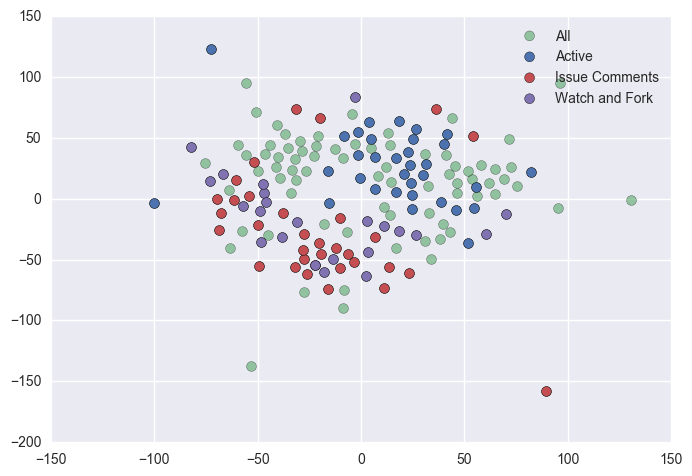

In [222]:
colors = sns.color_palette()

plt.scatter(*zip(*dimens), s=50, label='All', c=colors[1],alpha=.6)
# Pusher
activeness_mask = [1 if (x == 8).mean() > .75 else 0 for x in x_test]
plt.scatter(*zip(*[dimens[i] for i, v in enumerate(dimens) 
                   if activeness_mask[i]==1]), s=50, label='Active', 
                c=colors[0])
# Issue Commenter
passivemask = np.array([1 if ((x == 26) | (x == 21)| (x == 7) | (x == 12)).mean() > .2 else 0 for x in x_test])
plt.scatter(*zip(*[dimens[i] for i, v in enumerate(dimens) if passivemask[i]==1]), 
            s=50, label='Issue Comments', c=colors[2])

# Watch diff
watchmask = np.array([1 if ((x == 25) | (x == 17)).mean() > .2 else 0 for x in x_test])
plt.scatter(*zip(*[dimens[i] for i, v in enumerate(dimens) if watchmask[i]==1]), 
            s=50, label='Watch and Fork', c=colors[3])
plt.legend()

33


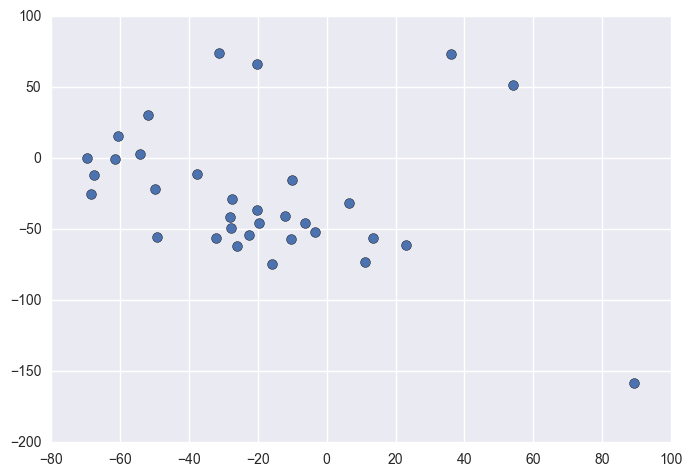

In [219]:
testmask = np.array([1 if ((x == 26) | (x == 21)| (x == 7) | (x == 12)).mean() > .2 else 0 for x in x_test])
print testmask.sum()

plt.scatter(*zip(*[dimens[i] for i, v in enumerate(dimens) if testmask[i]==1]), 
            s=50, label='Active Consumer', c=colors[0])

In [213]:
label_encodings = ['MemberEvent_same',
 'PublicEvent_same',
 'PullRequestReviewCommentEvent_same',
 'ForkEvent_same',
 'GollumEvent_same',
 'ReleaseEvent_same',
 'PullRequestEvent_same',
 'IssueCommentEvent_same',
 'PushEvent_same',
 'DeleteEvent_same',
 'CommitCommentEvent_same',
 'WatchEvent_same',
 'IssuesEvent_same',
 'CreateEvent_same',
 'MemberEvent_diff',
 'PublicEvent_diff',
 'PullRequestReviewCommentEvent_diff',
 'ForkEvent_diff',
 'GollumEvent_diff',
 'ReleaseEvent_diff',
 'PullRequestEvent_diff',
 'IssueCommentEvent_diff',
 'PushEvent_diff',
 'DeleteEvent_diff',
 'CommitCommentEvent_diff',
 'WatchEvent_diff',
 'IssuesEvent_diff',
 'CreateEvent_diff']

In [214]:
for i, l in enumerate(label_encodings):
    print i,l

0 MemberEvent_same
1 PublicEvent_same
2 PullRequestReviewCommentEvent_same
3 ForkEvent_same
4 GollumEvent_same
5 ReleaseEvent_same
6 PullRequestEvent_same
7 IssueCommentEvent_same
8 PushEvent_same
9 DeleteEvent_same
10 CommitCommentEvent_same
11 WatchEvent_same
12 IssuesEvent_same
13 CreateEvent_same
14 MemberEvent_diff
15 PublicEvent_diff
16 PullRequestReviewCommentEvent_diff
17 ForkEvent_diff
18 GollumEvent_diff
19 ReleaseEvent_diff
20 PullRequestEvent_diff
21 IssueCommentEvent_diff
22 PushEvent_diff
23 DeleteEvent_diff
24 CommitCommentEvent_diff
25 WatchEvent_diff
26 IssuesEvent_diff
27 CreateEvent_diff
